In [ ]:
! pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

import math
import itertools

# Adjustment set with 1 variable

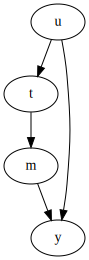

In [ ]:
fd0 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "t": discrete_model(["u"], {(0,): (0.3,0.7), (1,): (0.9,0.1)}),       
    # (0,): (0.5,0.5) means the following
    # given the value of input "0" (in this case we have only 1 input variable "u"), 
    # the resulting descrete values are generated with certain probability: 
    # 0 with probability 0.5 and 1 with probability 0.5
    "m": discrete_model(["t"], {(0,): (0.9, 0.1), (1,): (0.2, 0.8)}),
    "y": discrete_model(["m", "u"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.4, 0.6),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.7, 0.3),
    }),
    # (0, 0): (0.95, 0.05), means the following
    # given the value of input "0, 0" (in this case we have 2 input variables  "z" and "u"), 
    # the resulting descrete values are generated with certain probability: 
    # 0 with probability 0.95 and 1 with probability 0.05
})

fd0.cgm.draw()

In [ ]:
fd0.cgm.get_all_frontdoor_adjustment_sets('t', 'y')

frozenset({frozenset({'m'})})

In [ ]:
fd0.cgm.get_all_backdoor_adjustment_sets('t', 'y')

frozenset({frozenset({'u'})})

Estimate the true causal effect with a simulation of an experiment.

- Use 500000 instances of each value of treatment for estimation
- Perform estimation 10 times and round the result

Your solution

In [ ]:
# First sample the dataset
df0 = fd0.sample(n_samples=500000)

In [ ]:
df0.head()

,u,t,m,y
0,1,0.0,0.0,0.0
1,0,0.0,0.0,0.0
2,0,1.0,1.0,0.0
3,1,0.0,1.0,1.0
4,1,1.0,1.0,0.0


First store the true ate of fd0

In [ ]:
set_variable_t = np.array([0]*500000 + [1]*500000)
ab_test_df = fd0.do('t').sample(
                    set_values={'t': set_variable_t}, 
                    n_samples=len(set_variable_t),
                  )
ab_test_df.head()


true_ate_fd0 = ab_test_df[ab_test_df['t'] == 1]['y'].mean() - ab_test_df[ab_test_df['t'] == 0]['y'].mean()


In [ ]:
true_ate_fd0

-0.384602

Estimate ATE using frontdoor adjustment:

$ATE = E[Y|do(t=1)] - E[Y|do(t=0)]$

$E[Y|do(t)] = \sum_m P(m| t) \sum_{t'} E[Y|m, t'] P(t')$

Sample 1000000 observations from the model for calculations.

Compare your estimation with the true causal effect.

$E[Y|do(t=1)] = \sum_m P(m| t=1) \sum_{t'} E[Y|m, t'] P(t')$

$E[Y|do(t=1)] = \sum_m P(m| t=1) ( E[Y|m, t'=0] P(t'=0) + E[Y|m, t'=1] P(t'=1))$



$E[Y|do(t=1)] =  P(m=0| t=1) \left[ E[Y|m=0, t'=0] P(t'=0) + E[Y|m=0, t'=1] P(t'=1)\right] + P(m=1| t=1) \left[ E[Y|m=1, t'=0] P(t'=0) + E[Y|m=1, t'=1] P(t'=1)\right]$



Answers for intermediate steps

`Probabilities of t: [0.600145, 0.39985499999999996]`

`Probabilities of m|t=0: [0.8997425622141316, 0.10025743778586838]`

`Probabilities of m|t=1: [0.20083030098410673, 0.7991696990158933]`

`E_y_0_0 = 0.674442938204661`

`E_y_0_1 = 0.8632180615917213`

`E_y_1_0 = 0.2503282421180342`

`E_y_1_1 = 0.674442938204661`

`E[Y|do(t=1) = 0.31053464249294344`

`E[Y|do(t=0) = 0.694803138475164`

`ate = -0.3842684959822205`

`Error: 0.276%`

Your solution

Now calculate front-door adjustment estimation

In [ ]:
####### T = 1 ######
print("**** T = 1****")
inner_sum_terms = []

# for m = 0
print("# m = 0")

## for tt = 0

P_tt_0 = df0[df0['t'] == 0].shape[0] / df0.shape[0]
E_Y_cond_m_0_tt_0 =  df0.query('m == 0 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_0_tt_0", E_Y_cond_m_0_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df0[df0['t'] == 1].shape[0] / df0.shape[0]
E_Y_cond_m_0_tt_1 =  df0.query('m == 0 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_0_tt_1", E_Y_cond_m_0_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_0_tt_0 + P_tt_1 * E_Y_cond_m_0_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)

# for m = 1
print("# m = 1")

## for tt = 0
print("## tt = 0")
print("P_tt_0", P_tt_0)

P_tt_0 = df0[df0['t'] == 0].shape[0] / df0.shape[0]
E_Y_cond_m_1_tt_0 =  df0.query('y == 1 and m == 1 and t == 0').shape[0] / df0.query('m == 1 and t == 0').shape[0] 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_1_tt_0", E_Y_cond_m_1_tt_0)

## for tt = 1
print("## tt = 1")
P_tt_1 = df0[df0['t'] == 1].shape[0] / df0.shape[0]
E_Y_cond_m_1_tt_1 = df0.query('y == 1 and m == 1 and t == 1').shape[0]  / df0.query('m == 1 and t == 1').shape[0] 

print("P_tt_0", P_tt_1)
print("E_Y_cond_m_1_tt_1", E_Y_cond_m_1_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_1_tt_0 + P_tt_1 * E_Y_cond_m_1_tt_1)


inner_sum = sum(inner_sum_terms)

print("\n\ninnersum terms:", inner_sum_terms)
print("inner_sum: ", inner_sum)
print("\n\n\n")
P_m_0_cond_t = df0.query('m == 0 and t == 1').shape[0]  / df0.query('t == 1').shape[0]
P_m_1_cond_t = df0.query('m == 1 and t == 1').shape[0]  / df0.query('t == 1').shape[0]

print("P_m_0_cond_t", P_m_0_cond_t)
print("P_m_1_cond_t", P_m_1_cond_t)

outer_sum_t1 = inner_sum_terms[0] * P_m_0_cond_t + inner_sum_terms[1] * P_m_1_cond_t 


print("outer_sum_terms: ",  inner_sum_terms[0] * P_m_0_cond_t,  inner_sum_terms[1] * P_m_1_cond_t)

**** T = 1****
# m = 0
P_tt_0 0.598716
E_Y_cond_m_0_tt_0 0.674156261360517
## tt = 1
P_tt_1 0.401284
E_Y_cond_m_0_tt_1 0.8603403533286755


innersum terms: [0.7488689585218675]
# m = 1
## tt = 0
P_tt_0 0.598716
P_tt_0 0.598716
E_Y_cond_m_1_tt_0 0.24929492344883158
## tt = 1
P_tt_0 0.401284
E_Y_cond_m_1_tt_1 0.12291518752413338


innersum terms: [0.7488689585218675, 0.19858075749802498]
inner_sum:  0.9474497160198925




P_m_0_cond_t 0.19973883832896402
P_m_1_cond_t 0.800261161671036
outer_sum_terms:  0.14957821583577896 0.15891646768088377


In [ ]:
####### T = 0 ######
print("**** T = 0****")
inner_sum_terms = []

# for m = 0
print("# m = 0")

## for tt = 0
print("## tt = 0")


P_tt_0 = df0[df0['t'] == 0].shape[0] / df0.shape[0]
E_Y_cond_m_0_tt_0 =  df0.query('m == 0 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_0_tt_0", E_Y_cond_m_0_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df0[df0['t'] == 1].shape[0] / df0.shape[0]
E_Y_cond_m_0_tt_1 =  df0.query('m == 0 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_0_tt_1", E_Y_cond_m_0_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_0_tt_0 + P_tt_1 * E_Y_cond_m_0_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)

# for m = 1
print("# m = 1")

## for tt = 0
print("## tt = 0")

P_tt_0 = df0[df0['t'] == 0].shape[0] / df0.shape[0]
E_Y_cond_m_1_tt_0 =  df0.query('y == 1 and m == 1 and t == 0').shape[0] / df0.query('m == 1 and t == 0').shape[0] 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_1_tt_0", E_Y_cond_m_1_tt_0)

## for tt = 1
print("## tt = 1")

P_tt_1 = df0[df0['t'] == 1].shape[0] / df0.shape[0]
E_Y_cond_m_1_tt_1 = df0.query('y == 1 and m == 1 and t == 1').shape[0]  / df0.query('m == 1 and t == 1').shape[0] 

print("P_tt_0", P_tt_1)
print("E_Y_cond_m_1_tt_1", E_Y_cond_m_1_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_1_tt_0 + P_tt_1 * E_Y_cond_m_1_tt_1)


inner_sum = sum(inner_sum_terms)

print("\n\ninnersum terms:", inner_sum_terms)

print("\n\n\n")
P_m_0_cond_t = df0.query('m == 0 and t == 0').shape[0]  / df0.query('t == 0').shape[0]
P_m_1_cond_t = df0.query('m == 1 and t == 0').shape[0]  / df0.query('t == 0').shape[0]

print("P_m_0_cond_t", P_m_0_cond_t)
print("P_m_1_cond_t", P_m_1_cond_t)

outer_sum_t0 = inner_sum_terms[0] * P_m_0_cond_t + inner_sum_terms[1] * P_m_1_cond_t 

print("outer_sum_terms: ",  inner_sum_terms[0] * P_m_0_cond_t,  inner_sum_terms[1] * P_m_1_cond_t)

**** T = 0****
# m = 0
## tt = 0
P_tt_0 0.598716
E_Y_cond_m_0_tt_0 0.674156261360517
## tt = 1
P_tt_1 0.401284
E_Y_cond_m_0_tt_1 0.8603403533286755


innersum terms: [0.7488689585218675]
# m = 1
## tt = 0
P_tt_0 0.598716
E_Y_cond_m_1_tt_0 0.24929492344883158
## tt = 1
P_tt_0 0.401284
E_Y_cond_m_1_tt_1 0.12291518752413338


innersum terms: [0.7488689585218675, 0.19858075749802498]




P_m_0_cond_t 0.9005070851622472
P_m_1_cond_t 0.09949291483775279
outer_sum_terms:  0.6743618030070148 0.019757378394167437


In [ ]:
ATE = outer_sum_t1 - outer_sum_t0
ATE

-0.38562449788451947

Check if the estimation was close to the true ate depending on the adjustment set `['m']`



In [ ]:
 math.isclose(ATE, true_ate_fd0, rel_tol=1e-2) 

True

# Adjustment set with 2 variables

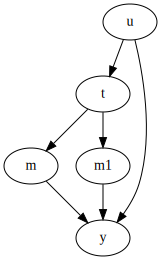

In [ ]:
fd2 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.3, size=n_samples),
    "t": discrete_model(["u"], {(0,): (0.1,0.9), (1,): (0.8,0.2)}),
    "m": discrete_model(["t"], {(0,): (0.7, 0.3), (1,): (0.1, 0.9)}),
    "m1": discrete_model(["t"], {(0,): (0.6, 0.4), (1,): (0.45, 0.55)}),
    "y": discrete_model(["m", "m1", "u"], {
        (0, 0, 0): (0.2, 0.8), 
        (0, 0, 1): (0.1, 0.9),
        (0, 1, 0): (0.6, 0.4), 
        (0, 1, 1): (0.4, 0.6),
        (1, 0, 0): (0.7, 0.3), 
        (1, 0, 1): (0.8, 0.2),
        (1, 1, 0): (0.8, 0.2), 
        (1, 1, 1): (0.7, 0.3),
    }),
})

fd2.cgm.draw()

In [ ]:
fd2.cgm.get_all_frontdoor_adjustment_sets('t', 'y')

frozenset({frozenset({'m', 'm1'})})

In [ ]:
fd2.cgm.get_all_backdoor_adjustment_sets('t', 'y')

frozenset({frozenset({'u'})})

First store the true ate of `fd2`



In [ ]:
# First sample the dataset
df2 = fd2.sample(n_samples=500000)

In [ ]:
df2.head()

,u,t,m,m1,y
0,1,0.0,0.0,1.0,0.0
1,0,1.0,1.0,0.0,0.0
2,0,1.0,1.0,0.0,1.0
3,0,1.0,1.0,0.0,0.0
4,0,1.0,1.0,0.0,0.0


In [ ]:
set_variable_t = np.array([0]*500000 + [1]*500000)
ab_test_df = fd2.do('t').sample(
                    set_values={'t': set_variable_t}, 
                    n_samples=len(set_variable_t),
                  )
ab_test_df.head()




,u,t,m,m1,y
0,0,0,1.0,0.0,1.0
1,0,0,0.0,0.0,0.0
2,1,0,0.0,0.0,1.0
3,1,0,0.0,0.0,1.0
4,0,0,1.0,1.0,0.0


In [ ]:
true_ate_fd2 = ab_test_df[ab_test_df['t'] == 1]['y'].mean() - ab_test_df[ab_test_df['t'] == 0]['y'].mean()
true_ate_fd2

-0.26707400000000003

Do the same for the model with the adjustment set containing 2 variables.

Hint, you can consider the case with 1 variable in the adjustment set, but the new variable now has 4 possible values: 
(0,0), (0,1), (1,0), (1,1).

Your solution

Now calculate front-door adjustment estimation

In [ ]:
####### T = 1 ######
print("**** T = 1****")
inner_sum_terms = []

# for m = 0 and m1 = 0
print("# m = 0")

## for tt = 0

P_tt_0 = df2[df2['t'] == 0].shape[0] / df2.shape[0]
E_Y_cond_m_0_m1_0_tt_0 =  df2.query('m == 0 and m1 == 0 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_0_m1_0_tt_0", E_Y_cond_m_0_m1_0_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df2[df2['t'] == 1].shape[0] / df2.shape[0]
E_Y_cond_m_0_m1_0_tt_1 =  df2.query('m == 0 and m1 == 0 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_0_m1_0_tt_1", E_Y_cond_m_0_m1_0_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_0_m1_0_tt_0 + P_tt_1 * E_Y_cond_m_0_m1_0_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)







# for m = 0 and m1 = 1

P_tt_0 = df2[df2['t'] == 0].shape[0] / df2.shape[0]
E_Y_cond_m_0_m1_1_tt_0 =  df2.query('m == 0 and m1 == 1 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_0_m1_1_tt_0", E_Y_cond_m_0_m1_1_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df2[df2['t'] == 1].shape[0] / df2.shape[0]
E_Y_cond_m_0_m1_1_tt_1 =  df2.query('m == 0 and m1 == 1 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_0_m1_1_tt_1", E_Y_cond_m_0_m1_1_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_0_m1_1_tt_0 + P_tt_1 * E_Y_cond_m_0_m1_1_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)




# for m = 1 and m1 = 0

P_tt_0 = df2[df2['t'] == 0].shape[0] / df2.shape[0]
E_Y_cond_m_1_m1_0_tt_0 =  df2.query('m == 1 and m1 == 0 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_1_m1_0_tt_0", E_Y_cond_m_1_m1_0_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df2[df2['t'] == 1].shape[0] / df2.shape[0]
E_Y_cond_m_1_m1_0_tt_1 =  df2.query('m == 1 and m1 == 0 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_1_m1_0_tt_1", E_Y_cond_m_1_m1_0_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_1_m1_0_tt_0 + P_tt_1 * E_Y_cond_m_1_m1_0_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)




# for m = 1 and m1 = 1

P_tt_0 = df2[df2['t'] == 0].shape[0] / df2.shape[0]
E_Y_cond_m_1_m1_1_tt_0 =  df2.query('m == 1 and m1 == 1 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_1_m1_1_tt_0", E_Y_cond_m_1_m1_1_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df2[df2['t'] == 1].shape[0] / df2.shape[0]
E_Y_cond_m_1_m1_1_tt_1 =  df2.query('m == 1 and m1 == 1 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_1_m1_1_tt_1", E_Y_cond_m_1_m1_1_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_1_m1_1_tt_0 + P_tt_1 * E_Y_cond_m_1_m1_1_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)






inner_sum = sum(inner_sum_terms)

print("\n\ninnersum terms:", inner_sum_terms)
print("inner_sum: ", inner_sum)
print("\n\n\n")


P_m_0_m1_0_cond_t = df2.query('m == 0 and m1 == 0 and t == 1').shape[0]  / df2.query('t == 1').shape[0]
P_m_0_m1_1_cond_t = df2.query('m == 0 and m1 == 1 and t == 1').shape[0]  / df2.query('t == 1').shape[0]
P_m_1_m1_0_cond_t = df2.query('m == 1 and m1 == 0 and t == 1').shape[0]  / df2.query('t == 1').shape[0]
P_m_1_m1_1_cond_t = df2.query('m == 1 and m1 == 1 and t == 1').shape[0]  / df2.query('t == 1').shape[0]

print("P_m_0_m1_0_cond_t", P_m_0_m1_0_cond_t)
print("P_m_0_m1_1_cond_t", P_m_0_m1_1_cond_t)
print("P_m_1_m1_0_cond_t", P_m_1_m1_0_cond_t)
print("P_m_1_m1_1_cond_t", P_m_1_m1_1_cond_t)

outer_sum_t1 = inner_sum_terms[0] * P_m_0_m1_0_cond_t + inner_sum_terms[1] * P_m_0_m1_1_cond_t + inner_sum_terms[2] * P_m_1_m1_0_cond_t + inner_sum_terms[3] * P_m_1_m1_1_cond_t             







**** T = 1****
# m = 0
P_tt_0 0.310676
E_Y_cond_m_0_m1_0_tt_0 0.8763042746549983
## tt = 1
P_tt_1 0.689324
E_Y_cond_m_0_m1_0_tt_1 0.8086547143041404


innersum terms: [0.8296718091157035]
P_tt_0 0.310676
E_Y_cond_m_0_m1_1_tt_0 0.5529395534913665
## tt = 1
P_tt_1 0.689324
E_Y_cond_m_0_m1_1_tt_1 0.42066361799425717


innersum terms: [0.8296718091157035, 0.46175857653075714]
P_tt_0 0.310676
E_Y_cond_m_1_m1_0_tt_0 0.22084944850307978
## tt = 1
P_tt_1 0.689324
E_Y_cond_m_1_m1_0_tt_1 0.29246577803326984


innersum terms: [0.8296718091157035, 0.46175857653075714, 0.2702163032401485]
P_tt_0 0.310676
E_Y_cond_m_1_m1_1_tt_0 0.2778166927097365
## tt = 1
P_tt_1 0.689324
E_Y_cond_m_1_m1_1_tt_1 0.20903700674708647


innersum terms: [0.8296718091157035, 0.46175857653075714, 0.2702163032401485, 0.23040520446321877]


innersum terms: [0.8296718091157035, 0.46175857653075714, 0.2702163032401485, 0.23040520446321877]
inner_sum:  1.792051893349828




P_m_0_m1_0_cond_t 0.04498900371958615
P_m_0_m1_1_cond_

In [ ]:
####### T = 0 ######
print("**** T = 1****")
inner_sum_terms = []

# for m = 0 and m1 = 0
print("# m = 0")

## for tt = 0

P_tt_0 = df2[df2['t'] == 0].shape[0] / df2.shape[0]
E_Y_cond_m_0_m1_0_tt_0 =  df2.query('m == 0 and m1 == 0 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_0_m1_0_tt_0", E_Y_cond_m_0_m1_0_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df2[df2['t'] == 1].shape[0] / df2.shape[0]
E_Y_cond_m_0_m1_0_tt_1 =  df2.query('m == 0 and m1 == 0 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_0_m1_0_tt_1", E_Y_cond_m_0_m1_0_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_0_m1_0_tt_0 + P_tt_1 * E_Y_cond_m_0_m1_0_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)







# for m = 0 and m1 = 1

P_tt_0 = df2[df2['t'] == 0].shape[0] / df2.shape[0]
E_Y_cond_m_0_m1_1_tt_0 =  df2.query('m == 0 and m1 == 1 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_0_m1_1_tt_0", E_Y_cond_m_0_m1_1_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df2[df2['t'] == 1].shape[0] / df2.shape[0]
E_Y_cond_m_0_m1_1_tt_1 =  df2.query('m == 0 and m1 == 1 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_0_m1_1_tt_1", E_Y_cond_m_0_m1_1_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_0_m1_1_tt_0 + P_tt_1 * E_Y_cond_m_0_m1_1_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)




# for m = 1 and m1 = 0

P_tt_0 = df2[df2['t'] == 0].shape[0] / df2.shape[0]
E_Y_cond_m_1_m1_0_tt_0 =  df2.query('m == 1 and m1 == 0 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_1_m1_0_tt_0", E_Y_cond_m_1_m1_0_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df2[df2['t'] == 1].shape[0] / df2.shape[0]
E_Y_cond_m_1_m1_0_tt_1 =  df2.query('m == 1 and m1 == 0 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_1_m1_0_tt_1", E_Y_cond_m_1_m1_0_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_1_m1_0_tt_0 + P_tt_1 * E_Y_cond_m_1_m1_0_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)




# for m = 1 and m1 = 1

P_tt_0 = df2[df2['t'] == 0].shape[0] / df2.shape[0]
E_Y_cond_m_1_m1_1_tt_0 =  df2.query('m == 1 and m1 == 1 and t == 0')['y'].mean() 

print("P_tt_0", P_tt_0)
print("E_Y_cond_m_1_m1_1_tt_0", E_Y_cond_m_1_m1_1_tt_0)
 
## for tt = 1
print("## tt = 1")


P_tt_1 = df2[df2['t'] == 1].shape[0] / df2.shape[0]
E_Y_cond_m_1_m1_1_tt_1 =  df2.query('m == 1 and m1 == 1 and t == 1')['y'].mean() 

print("P_tt_1", P_tt_1)
print("E_Y_cond_m_1_m1_1_tt_1", E_Y_cond_m_1_m1_1_tt_1)

inner_sum_terms.append(P_tt_0 * E_Y_cond_m_1_m1_1_tt_0 + P_tt_1 * E_Y_cond_m_1_m1_1_tt_1)

print("\n\ninnersum terms:", inner_sum_terms)






inner_sum = sum(inner_sum_terms)

print("\n\ninnersum terms:", inner_sum_terms)
print("inner_sum: ", inner_sum)
print("\n\n\n")


P_m_0_m1_0_cond_t = df2.query('m == 0 and m1 == 0 and t == 0').shape[0]  / df2.query('t == 0').shape[0]
P_m_0_m1_1_cond_t = df2.query('m == 0 and m1 == 1 and t == 0').shape[0]  / df2.query('t == 0').shape[0]
P_m_1_m1_0_cond_t = df2.query('m == 1 and m1 == 0 and t == 0').shape[0]  / df2.query('t == 0').shape[0]
P_m_1_m1_1_cond_t = df2.query('m == 1 and m1 == 1 and t == 0').shape[0]  / df2.query('t == 0').shape[0]

print("P_m_0_m1_0_cond_t", P_m_0_m1_0_cond_t)
print("P_m_0_m1_1_cond_t", P_m_0_m1_1_cond_t)
print("P_m_1_m1_0_cond_t", P_m_1_m1_0_cond_t)
print("P_m_1_m1_1_cond_t", P_m_1_m1_1_cond_t)

outer_sum_t0 = inner_sum_terms[0] * P_m_0_m1_0_cond_t + inner_sum_terms[1] * P_m_0_m1_1_cond_t + inner_sum_terms[2] * P_m_1_m1_0_cond_t + inner_sum_terms[3] * P_m_1_m1_1_cond_t             







**** T = 1****
# m = 0
P_tt_0 0.310676
E_Y_cond_m_0_m1_0_tt_0 0.8763042746549983
## tt = 1
P_tt_1 0.689324
E_Y_cond_m_0_m1_0_tt_1 0.8086547143041404


innersum terms: [0.8296718091157035]
P_tt_0 0.310676
E_Y_cond_m_0_m1_1_tt_0 0.5529395534913665
## tt = 1
P_tt_1 0.689324
E_Y_cond_m_0_m1_1_tt_1 0.42066361799425717


innersum terms: [0.8296718091157035, 0.46175857653075714]
P_tt_0 0.310676
E_Y_cond_m_1_m1_0_tt_0 0.22084944850307978
## tt = 1
P_tt_1 0.689324
E_Y_cond_m_1_m1_0_tt_1 0.29246577803326984


innersum terms: [0.8296718091157035, 0.46175857653075714, 0.2702163032401485]
P_tt_0 0.310676
E_Y_cond_m_1_m1_1_tt_0 0.2778166927097365
## tt = 1
P_tt_1 0.689324
E_Y_cond_m_1_m1_1_tt_1 0.20903700674708647


innersum terms: [0.8296718091157035, 0.46175857653075714, 0.2702163032401485, 0.23040520446321877]


innersum terms: [0.8296718091157035, 0.46175857653075714, 0.2702163032401485, 0.23040520446321877]
inner_sum:  1.792051893349828




P_m_0_m1_0_cond_t 0.4207727664834104
P_m_0_m1_1_cond_t

In [ ]:
ATE = outer_sum_t1 - outer_sum_t0
ATE


-0.2684296216546138

Check if the estimation was close to the true ate depending on the adjustment set `['m', 'm1']`



In [ ]:
 math.isclose(ATE, true_ate_fd2, rel_tol=1e-2) 

True

# Assignment

1. Implement a function for calculating ATE using front-door adjustment for an arbitrary number of adjusting variables. You can assume that all variables are binary. 

2. Compare your results with back-door adjustment. Note, that we assumed variable 𝑈 to be unobserved, however it is not.

3. Demostrate your code for 1, 2 and 3 (or more) adjusting variables.

First I define the function `my_frontdoor_adjustment_descrete`



In [ ]:
def my_frontdoor_adjustment_descrete(data=df0, T='t', Y='y', cond_set = ['m'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    if len(cond_set) == 0:
      T_values = data[T].unique().astype(int).tolist()
      T_values.sort()
      ATE_terms = []
      counter = 0
      for tt in T_values:
          ATE_terms.append(0)
          # forumulate a query of the current of value of  to search in dataframe
          q = f'{t} == {tt}'
          ## Calucate expectation of Y based on values of X
          E_Y = data.query(q)[Y].mean()
          ## Calculate E_Y conditioned on nq (query q + value of x)
          ## the condition has all values of the confounders and also the value of x
          ATE_terms[counter] += E_Y
          counter += 1;
      ## Since X (treatment) has 2 values, the following quantity would be just ATE[1] - ATE[0]
      #ATE = ATE_terms[-1] - sum(ATE_terms[:-1])  
      ATE = ATE_terms[1] - ATE_terms[0]
      # Also, if we assumed T only takes the two values in [0,1], instead of for loop we would have just written the following:
      #ATE = data[data[T] == 1][Y].mean() - data[data[T] == 0][Y].mean()
    else:
      variable_values = []
      n = len(cond_set)
      ## list of lists that inner list (i) contain all values of ith variable in cond_set
      variable_values = [data[cond_set[i]].unique().astype(int).tolist() for i in range(n)]
      ## convert every value to character
      variable_values_char = [list(map(str, variable)) for variable in variable_values]
      ## construct all possible combination of values for variables of cond_set
      combinations = list(itertools.product(*variable_values_char ))
      print(combinations)
      ## now using the combinations we construct all possible queries within the data (dataframe)
      queries = []
      for i in range(len(combinations)):
        query_string = ''
        for j in range(n):
          query_string += f'{cond_set[j]} == {combinations[i][j]} and '
          if j == n-1:
            # remove the last " and " from the string 
            queries.append(query_string[:-5])
      ## example of an element in the queries list: 'A == 0 and K == 0'      
      ATE = 0
      ## Obtain possible values of X
      T_values = data[T].unique().astype(int).tolist()
      T_values.sort()
      # T = 1 #
      outer_sum_t1 = []
      inner_sum_m = []
      counter = 0
      for q in queries:
        inner_sum_t = 0
        for tt in T_values: 
          ## Add current value of t to the query q (q is obtained from list of all possible queries, over which we are iterating)
          ## example of q: "m == 1 and m1 == 0"
          ## example of nq: "tt == 0 and m == 1 and m1 == 0"
          nq = f'{T} == {tt} and ' + q
          P_T_tt = data[data[T] == tt].shape[0] / data.shape[0]   
          ## Calucate expectation of Y based on values of cond_set as well as T
          ## In another words, based on the new query (nq) that adds current value of tt to the query
          E_Y_cond_M_T_tt =  data.query(nq)[Y].mean() 
          ## the condition has all values of the confounders and also the value of x
          inner_sum_t += P_T_tt * E_Y_cond_M_T_tt
        inner_sum_m.append(inner_sum_t) 
        qt1 = f'{T} == {1} and ' + q   
        P_M_cond_T_1 = data.query(qt1).shape[0] / data.query((f'{T} == {1}')).shape[0]
        outer_sum_t1.append(P_M_cond_T_1 * inner_sum_m[counter])
        counter += 1

      # T = 0 #
      # same commands as before but put t = 0 in formula
      outer_sum_t0 = []
      inner_sum_m = []
      counter = 0
      for q in queries:
        inner_sum_t = 0
        for tt in T_values: 
          nq = f'{T} == {tt} and ' + q
          P_T_tt = data[data[T] == tt].shape[0] / data.shape[0]  
          E_Y_cond_M_T_tt = data.query(nq)[Y].mean() 
          inner_sum_t += P_T_tt * E_Y_cond_M_T_tt
        inner_sum_m.append(inner_sum_t)
        qt0 = f'{T} == {0} and ' + q   
        P_M_cond_T_0 = data.query(qt0).shape[0] / data.query(f'{T} == {0}').shape[0]
        outer_sum_t0.append(P_M_cond_T_0 * inner_sum_m[counter])
        counter += 1
      ATE = sum(outer_sum_t1) - sum(outer_sum_t0)
    print(f"ATE for set {cond_set}: {ATE}")
    if math.isclose(ATE, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False    

**fd0**

In [ ]:
my_frontdoor_adjustment_descrete(data = df0, cond_set=['m'],true_ate = true_ate_fd0)

[('0',), ('1',)]
ATE for set ['m']: -0.38562449788451947


True

**fd2**

In [ ]:
my_frontdoor_adjustment_descrete(data = df2, cond_set=['m'],true_ate = true_ate_fd2)

[('0',), ('1',)]
ATE for set ['m']: -0.23891118089375107


False

In [ ]:
my_frontdoor_adjustment_descrete(data = df2, cond_set=['m','m1'],true_ate = true_ate_fd2)

[('0', '1'), ('0', '0'), ('1', '1'), ('1', '0')]
ATE for set ['m', 'm1']: -0.2684296216546137


True

In [ ]:
my_frontdoor_adjustment_descrete(data = df2, cond_set=['m'],true_ate = true_ate_fd2)

[('0',), ('1',)]
ATE for set ['m']: -0.23891118089375107


False

In [ ]:
my_frontdoor_adjustment_descrete(data = df2, cond_set=['m1'],true_ate = true_ate_fd2)

[('1',), ('0',)]
ATE for set ['m1']: -0.021826955196891207


False

The result of my implemented function `my_frontdoor_adjustment_descrete` coincides with those of the built-in function `get_all_frontdoor_adjustment_sets`





I recall the `my_backdoor_adjustment_descrete` function in order to compare its results:



In [ ]:
def my_backdoor_adjustment_descrete(data=df0, T='t', Y='y', cond_set = ['m'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    if len(cond_set) == 0:
      X_values = data[T].unique().astype(int).tolist()
      X_values.sort()
      ATE_terms = []
      counter = 0
      for x in X_values:
          ATE_terms.append(0)
          # forumulate a query of the current of value of x to search in dataframe
          q = f'{T} == {x}'
          #print(nq)
          ## Calucate expectation of Y based on values of X
          E_Y = data.query(q)[Y].mean()
          ## Calculate E_Y conditioned on nq (query q + value of x)
          ## the condition has all values of the confounders and also the value of x
          ATE_terms[counter] += E_Y
          counter += 1;
      ## Since X (treatment) has 2 values, the following quantity would be just ATE[1] - ATE[0]
      #ATE = ATE_terms[-1] - sum(ATE_terms[:-1])  
      ATE = ATE_terms[1] - ATE_terms[0]
      # Also, if we assumed T only takes the two values in [0,1], instead of for loop we would have just written the following:
      #ATE = data[data[T] == 1][Y].mean() - data[data[T] == 0][Y].mean()
    else:
      variable_values = []
      n = len(cond_set)
      ## list of lists that inner list (i) contain all values of ith variable in cond_set
      variable_values = [data[cond_set[i]].unique().astype(int).tolist() for i in range(n)]
      ## convert every value to character
      variable_values_char = [list(map(str, variable)) for variable in variable_values]
      ## construct all possible combination of values for variables of cond_set
      combinations = list(itertools.product(*variable_values_char ))
      ## now using the combinations we construct all possible queries within the data (dataframe)
      queries = []
      for i in range(len(combinations)):
        query_string = ''
        for j in range(n):
          query_string += f'{cond_set[j]} == {combinations[i][j]} and '
          if j == n-1:
            # remove the last " and " from the string 
            queries.append(query_string[:-5])
      ## example of an element in the queries list: 'A == 0 and K == 0'      
      ATE = 0
      ## Obtain possible values of X
      X_values = data[T].unique().astype(int).tolist()
      X_values.sort()
      ATE_terms = []
      counter = 0
      for x in X_values:
        ATE_terms.append(0)
        for q in queries:
          ## Add current value of x to the query q (q is obtained from list of all possible queries, over which we are iterating)
          ## example of q: "A == 1 and K == 0"
          ## example of nq: "X == 0 and A == 1 and K == 0"
          nq = f'{T} == {x} and ' + q
          #print(nq)
          ## Probability of the event q occurring
          size = data.query(q).shape[0] / data.shape[0]
          ## Calucate expectation of Y based on the new query (nq) that adds current values of x to the query
          E_Y = data.query(nq)[Y].mean()
          ## Calculate E_Y conditioned on nq (query q + value of x)
          ## the condition has all values of the confounders and also the value of x
          ATE_terms[counter] += size * E_Y
        counter += 1;
      ## Since X (treatment) has 2 values, the following quantity would be just ATE[1] - ATE[0]
      #ATE = ATE_terms[-1] - sum(ATE_terms[:-1])  
      ATE = ATE_terms[1] - ATE_terms[0]
    print(f"ATE for set {cond_set}: {ATE}")
    if math.isclose(ATE, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False    

In [ ]:
my_backdoor_adjustment_descrete(data = df0, cond_set=['m'],true_ate = true_ate_fd0)

ATE for set ['m']: 0.06719104268934806


False

In [ ]:
my_backdoor_adjustment_descrete(data = df0, cond_set=['u'],true_ate = true_ate_fd0)

ATE for set ['u']: -0.3848650450768184


True

In [ ]:
my_backdoor_adjustment_descrete(data = df0, cond_set=['u','m'],true_ate = true_ate_fd0)

ATE for set ['u', 'm']: 0.0002659412172180686


False

In [ ]:
my_backdoor_adjustment_descrete(data = df2, cond_set=['m','m1'], true_ate = true_ate_fd2)

ATE for set ['m', 'm1']: -0.029591150000829514


False

In [ ]:
my_backdoor_adjustment_descrete(data = df2, cond_set=['u','m','m1'], true_ate = true_ate_fd2)

ATE for set ['u', 'm', 'm1']: 0.004497313674758585


False

In [ ]:
my_backdoor_adjustment_descrete(data = df2, cond_set=['u'], true_ate = true_ate_fd2)

ATE for set ['u']: -0.2665304884763155


True

The result of my implemented function `my_backdoor_adjustment_descrete` coincides with those of the built-in function `get_all_backdoor_adjustment_sets`.


We see that for fd0, frontdoor_adjustment reports `['m']` as the adjustment set, whereas backdoor_adjustment reports `['u']` as adjustment set. This is due to the already stated reason that in frontdoor_adjustment, we assume that confounders ($U$ in this case) are unobserved, which is not true.



In below, result of the `my_frontdoor_adjustment_descrete` function is provided with printing of variables in all the for loops in order to clatify and trace its steps:



```
my_frontdoor_adjustment_descrete(data = df0, cond_set=['m'],true_ate = true_ate_fd0)


[('1',), ('0',)]
****T = 1****



#query:m == 1

##tt = 0
P_T_0:  0.59872
E_Y_cond_M_T_0:  0.24932717546599328


##tt = 1
P_T_1:  0.40128
E_Y_cond_M_T_1:  0.1248231811808693


inner_sum_m:  [0.19936621263925874]
qt1:  t == 1 and m == 1
P_M_cond_T_1 0.7998155901116427



inner_sum_m[counter]:  0.19936621263925874
#query:m == 0

##tt = 0
P_T_0:  0.59872
E_Y_cond_M_T_0:  0.6753062990459142


##tt = 1
P_T_1:  0.40128
E_Y_cond_M_T_1:  0.8605751275986555


inner_sum_m:  [0.19936621263925874, 0.7496509745675584]
qt1:  t == 1 and m == 0
P_M_cond_T_1 0.20018440988835726



inner_sum_m[counter]:  0.7496509745675584
outer sum (t = 1):  [0.15945620501039198, 0.15006843796603858]








****T = 0****



#query:m == 1

##tt = 0
P_T_0:  0.59872
E_Y_cond_M_T_0:  0.24932717546599328


##tt = 1
P_T_1:  0.40128
E_Y_cond_M_T_1:  0.1248231811808693


inner_sum_m:  [0.19936621263925874]
qt0:  t == 0 and m == 1
P_M_cond_T_0 0.10053781400320684



inner_sum_m[counter]:  0.19936621263925874
#query:m == 0

##tt = 0
P_T_0:  0.59872
E_Y_cond_M_T_0:  0.6753062990459142


##tt = 1
P_T_1:  0.40128
E_Y_cond_M_T_1:  0.8605751275986555


inner_sum_m:  [0.19936621263925874, 0.7496509745675584]
qt0:  t == 0 and m == 0
P_M_cond_T_0 0.8994621859967932



inner_sum_m[counter]:  0.7496509745675584
outer sum (t = 0):  [0.02004384320484958, 0.6742827043191625]
ATE for set ['m']: -0.38480190454758145
True
```





```
my_frontdoor_adjustment_descrete(data = df2, cond_set=['m', 'm1'],true_ate = true_ate_fd2)


[('1', '0'), ('1', '1'), ('0', '0'), ('0', '1')]
****T = 1****



#query:m == 1 and m1 == 0

##tt = 0
P_T_0:  0.30952
E_Y_cond_M_T_0:  0.2264961856667025


##tt = 1
P_T_1:  0.69048
E_Y_cond_M_T_1:  0.29180201193423294


inner_sum_m:  [0.27158855258790693]
qt1:  t == 1 and m == 1 and m1 == 0
P_M_cond_T_1 0.4048372146912293



inner_sum_m[counter]:  0.27158855258790693
#query:m == 1 and m1 == 1

##tt = 0
P_T_0:  0.30952
E_Y_cond_M_T_0:  0.2772570566688214


##tt = 1
P_T_1:  0.69048
E_Y_cond_M_T_1:  0.21071192159665392


inner_sum_m:  [0.27158855258790693, 0.2313089718041912]
qt1:  t == 1 and m == 1 and m1 == 1
P_M_cond_T_1 0.4944589271231607



inner_sum_m[counter]:  0.2313089718041912
#query:m == 0 and m1 == 0

##tt = 0
P_T_0:  0.30952
E_Y_cond_M_T_0:  0.8792293521645687


##tt = 1
P_T_1:  0.69048
E_Y_cond_M_T_1:  0.8054880388895996


inner_sum_m:  [0.27158855258790693, 0.2313089718041912, 0.8283124501744681]
qt1:  t == 1 and m == 0 and m1 == 0
P_M_cond_T_1 0.045284439809987254



inner_sum_m[counter]:  0.8283124501744681
#query:m == 0 and m1 == 1

##tt = 0
P_T_0:  0.30952
E_Y_cond_M_T_0:  0.553402109655732


##tt = 1
P_T_1:  0.69048
E_Y_cond_M_T_1:  0.4152511367793864


inner_sum_m:  [0.27158855258790693, 0.2313089718041912, 0.8283124501744681, 0.45801162590407285]
qt1:  t == 1 and m == 0 and m1 == 1
P_M_cond_T_1 0.05541941837562275



inner_sum_m[counter]:  0.45801162590407285
outer sum (t = 1):  [0.1099491531717107, 0.11437278603226181, 0.03750966529378877, 0.025382737916877028]








****T = 0****



#query:m == 1 and m1 == 0

##tt = 0
P_T_0:  0.30952
E_Y_cond_M_T_0:  0.2264961856667025


##tt = 1
P_T_1:  0.69048
E_Y_cond_M_T_1:  0.29180201193423294


inner_sum_m:  [0.27158855258790693]
qt0:  t == 0 and m == 1 and m1 == 0
P_M_cond_T_0 0.18041483587490306



inner_sum_m[counter]:  0.27158855258790693
#query:m == 1 and m1 == 1

##tt = 0
P_T_0:  0.30952
E_Y_cond_M_T_0:  0.2772570566688214


##tt = 1
P_T_1:  0.69048
E_Y_cond_M_T_1:  0.21071192159665392


inner_sum_m:  [0.27158855258790693, 0.2313089718041912]
qt0:  t == 0 and m == 1 and m1 == 1
P_M_cond_T_0 0.11995347635047816



inner_sum_m[counter]:  0.2313089718041912
#query:m == 0 and m1 == 0

##tt = 0
P_T_0:  0.30952
E_Y_cond_M_T_0:  0.8792293521645687


##tt = 1
P_T_1:  0.69048
E_Y_cond_M_T_1:  0.8054880388895996


inner_sum_m:  [0.27158855258790693, 0.2313089718041912, 0.8283124501744681]
qt0:  t == 0 and m == 0 and m1 == 0
P_M_cond_T_0 0.4209097958128715



inner_sum_m[counter]:  0.8283124501744681
#query:m == 0 and m1 == 1

##tt = 0
P_T_0:  0.30952
E_Y_cond_M_T_0:  0.553402109655732


##tt = 1
P_T_1:  0.69048
E_Y_cond_M_T_1:  0.4152511367793864


inner_sum_m:  [0.27158855258790693, 0.2313089718041912, 0.8283124501744681, 0.45801162590407285]
qt0:  t == 0 and m == 0 and m1 == 1
P_M_cond_T_0 0.27872189196174724



inner_sum_m[counter]:  0.45801162590407285
outer sum (t = 0):  [0.04899860414064971, 0.027746315278967468, 0.3486448242721947, 0.12765786691245917]
ATE for set ['m', 'm1']: -0.2658332681896327
True
```

